#### Poisson Equation in 2D

In [1]:
from subprocess import run
import time

import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import curve_fit

from poisson import Poisson2D

In [2]:
def ref_func(x, y):
    return y*(1-y)*x**3

def source_term(x, y):
    return 6*x*y*(1-y)-2*x**3

def linear_model(x, a, b):
    return a * x + b

The figure below is what analytical solution looks like under a 512-by-512 grid.

/Users/jimmy/Desktop/School/NTU/112-2/計算天文物理/CGPoisson/poisson.py:59: UserWarning: Fall back to cpu for PyTorch
  warnings.warn("Fall back to cpu for PyTorch")


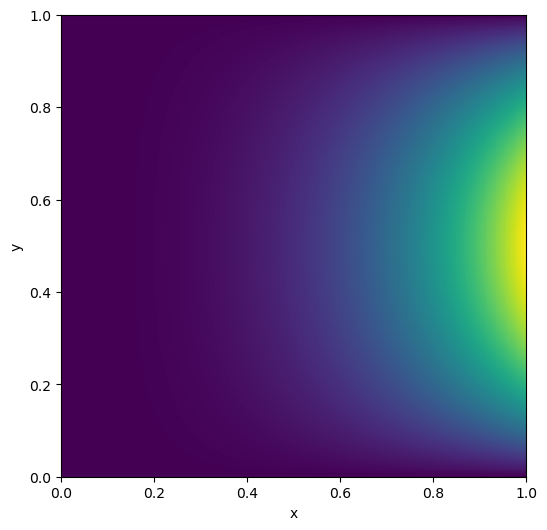

In [3]:
N=512
poisson = Poisson2D(N=N)

x = poisson.x.cpu()

ref = ref_func(x[:, None], x[None, :])
fig = plt.figure(figsize=(6, 6))
fig.gca().pcolormesh(np.linspace(0, 1, N+1), np.linspace(0, 1, N+1), ref.T)
fig.gca().set_xlabel("x")
fig.gca().set_ylabel("y")
plt.show()

In [4]:
schemes = ["CG", "Gauss-Seidel", "SOR"]
schemes = ["CG"]
resolution = np.array([8, 16, 32, 64, 100])
error_all = []
iters_all = []
wall_time_all = []

for scheme in schemes:
    error = []
    iters = []
    wall_time = []

    for N in resolution:
        poisson = Poisson2D(N=N)

        x = poisson.x.cpu().numpy()
        ref = ref_func(x[:, None], x[None, :])
        BC = np.zeros((N+2, N+2))
        BC[-1, 1:-1] = x * (1 - x)
        source = source_term(x[:, None], x[None, :])

        if scheme == "SOR":
            t1 = time.time()
            poisson.run(scheme=scheme, steps=None,
                        BC=torch.tensor(BC, device=poisson.device),
                        source=torch.tensor(source, device=poisson.device),
                        w=1.6905, terminate=1e-12)
            t2 = time.time()
        else:
            t1 = time.time()
            poisson.run(scheme=scheme, steps=None, BC=torch.tensor(BC, device=poisson.device),
                        source=torch.tensor(source, device=poisson.device), terminate=1e-12)
            t2 = time.time()

        error.append(np.abs(poisson.u.cpu().numpy()[1:-1, 1:-1] - ref).sum() / N**2)
        print(error)
        iters.append(poisson.steps)
        wall_time.append(t2 - t1)

    error_all.append(error)
    iters_all.append(iters)
    wall_time_all.append(wall_time)

[0.005581530987085255]
[0.005581530987085255, 0.0031432680088182945]
[0.005581530987085255, 0.0031432680088182945, 0.0016791298372627154]
[0.005581530987085255, 0.0031432680088182945, 0.0016791298372627154, 0.0008661596764250056]
[0.005581530987085255, 0.0031432680088182945, 0.0016791298372627154, 0.0008661596764250056, 0.0005607597522304027]


100


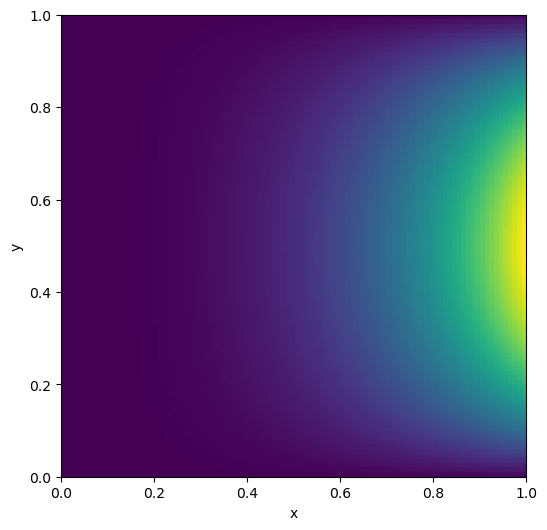

In [5]:
sol = poisson.u.numpy()[1:-1, 1:-1]
print(resolution[-1])

fig = plt.figure(figsize=(6, 6))
fig.gca().pcolormesh(np.linspace(0, 1, resolution[-1]+1), np.linspace(0, 1, resolution[-1]+1), sol.T)
fig.gca().set_xlabel("x")
fig.gca().set_ylabel("y")
plt.show()

# compiler Compare solution with C++ version

In [6]:
# modify the string below to use your compiler
compiler="/usr/local/Cellar/gcc/14.1.0/bin/g++-14"

run(f"{compiler} -fopenmp CGPoisson.cpp -o CGPoisson.out", shell=True)

CompletedProcess(args='/usr/local/Cellar/gcc/14.1.0/bin/g++-14 -fopenmp CGPoisson.cpp -o CGPoisson.out', returncode=0)

In [7]:
for N in resolution:
    poisson = Poisson2D(N=N)
    x = poisson.x.cpu()
    dx = poisson.dx
    BC = np.zeros((N+2, N+2))
    BC[-1, 1:-1] = x.numpy() * (1 - x.numpy())

    source = source_term(x[:, None], x[None, :])

    init_cond = BC
    init_cond[1:-1, 1:-1] = source

    np.savetxt(f"boundary_source_{N}.dat", init_cond.reshape(1, -1), "%.18f")

    run(f"./CGPoisson.out boundary_source_{N}.dat {dx}", shell=True)

step 23, avg residual=2.624142e-17, max residual=9.297572e-17
step 55, avg residual=7.110295e-13, max residual=3.009518e-12
step 112, avg residual=5.748976e-13, max residual=2.318803e-12
step 224, avg residual=9.863537e-13, max residual=4.982632e-12
step 371, avg residual=8.811593e-13, max residual=4.861982e-12


8


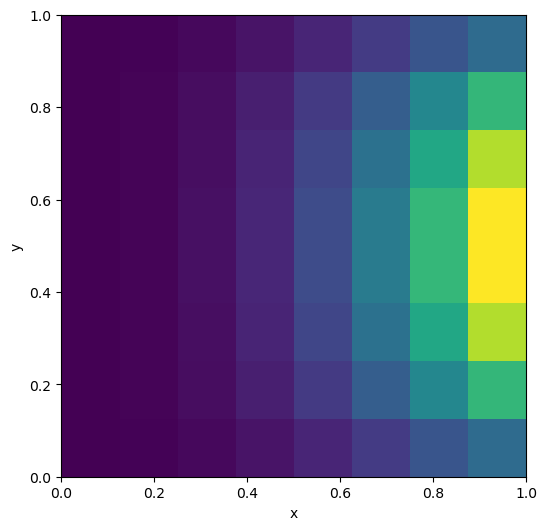

16


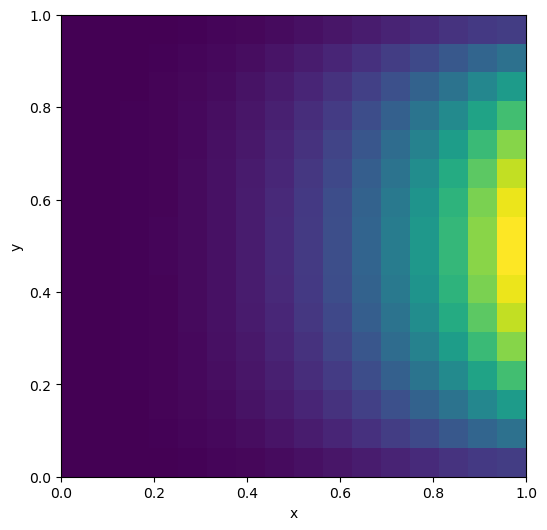

32


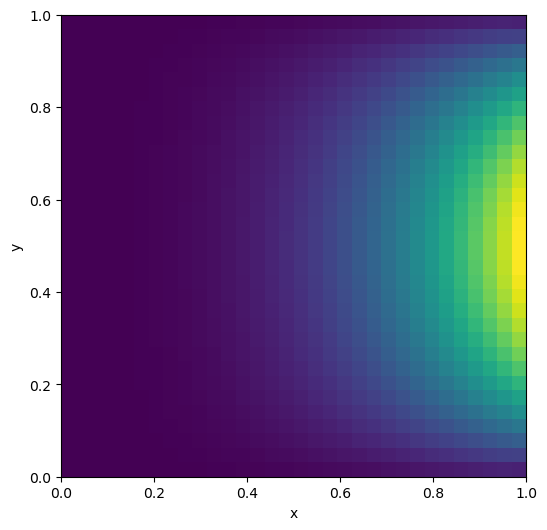

64


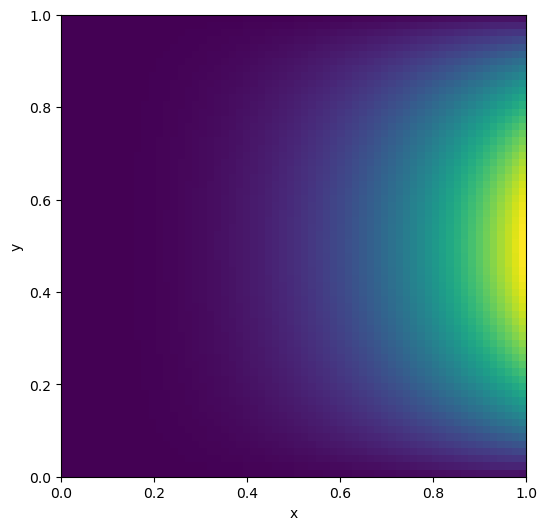

100


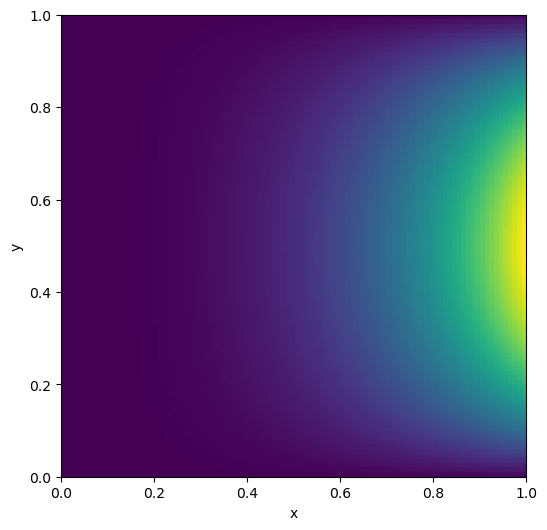

In [8]:
for N in resolution:
    sol = np.loadtxt(f"output_{N}.txt")
    N_sol = int(np.sqrt(sol.shape)[0])
    sol_plot = sol.reshape(-1, N_sol, order='C')[1:-1, 1:-1]
    print(N_sol-2)

    fig = plt.figure(figsize=(6, 6))
    fig.gca().pcolormesh(np.linspace(0, 1, N_sol-1), np.linspace(0, 1, N_sol-1), sol_plot.T)
    fig.gca().set_xlabel("x")
    fig.gca().set_ylabel("y")
    plt.show()

Compare the scaling between spatial resolutions and errors, iterations required and wall times required.

The scaling between resolutions and errors is expected to be (inversely) second-order. However, as shown in the first figure below, I get a scaling of (inversely) first order.

As shown in the second figure below, the scaling between resolutions and iterations required for convergence is close to second order.

As shown in the third figure below, the scaling between resolutions and wall-time required for convergence is close to fourth order.

#### Compare CG with Gauss-Sidual & SOR

In [ ]:
fig1, axes1 = plt.subplots(figsize=(6, 6), dpi=150)
fig2, axes2 = plt.subplots(figsize=(6, 6), dpi=150)
fig3, axes3 = plt.subplots(figsize=(6, 6), dpi=150)

for i, err in enumerate(error_all):
    fig1.gca().scatter(np.array(resolution)*(1+0.01*i), err, label=schemes[i])
    fig1.gca().set_yscale("log", base=10)
    fig1.gca().set_xscale("log", base=2)
    fig1.gca().set_xlabel("N - Spatial resolution")
    fig1.gca().set_ylabel("Error")

for i, iter in enumerate(iters_all):
    fig2.gca().scatter(resolution, iter, label=schemes[i])
    fig2.gca().set_yscale("log", base=10)
    fig2.gca().set_xscale("log", base=2)
    fig2.gca().set_xlabel("N - Spatial resolution")
    fig2.gca().set_ylabel("Iterations until convergence")

for i, _wall_time in enumerate(wall_time_all):
    fig3.gca().scatter(resolution, _wall_time, label=schemes[i])
    fig3.gca().set_yscale("log", base=10)
    fig3.gca().set_xscale("log", base=2)
    fig3.gca().set_xlabel("N - Spatial resolution")
    fig3.gca().set_ylabel("Wall time required for convergence")


res = np.linspace(resolution[0], resolution[-1], 1000)
#fig1.gca().plot(res, res**(-2), label=r"$f(x) \propto x^{-2}$", c='C3')
# fig1.gca().plot(res, 5e-2*res**(-1), label=r"$f(x) \propto x^{-1}$", c='C4')
# fig2.gca().plot(res, 3*res**(1.9), label=r"$f(x) \propto x^{1.9}$", c='C3')
# fig2.gca().plot(res, 0.48*res**(2), label=r"$f(x) \propto x^{2}$", c='C4')
fig3.gca().plot(res, 1e-6*res**(4), label=r"$f(x) \propto x^{4}$", c='C3')
fig1.gca().legend()
fig2.gca().legend()
fig3.gca().legend()

plt.show()

#### CPU parallelize vs GPU parallelize

In [ ]:
schemes = ["CG"]
resolution = np.array([2,4,8,16,32,64,128,256,512,1024,2048])
error_all = []
iters_all = []
wall_time_all = []

for scheme in schemes:


    for device in ['cpu', 'cuda']:
        error = []
        iters = []
        wall_time = []

        for N in resolution:
            poisson = Poisson2D(N=N, device = device)

            x = poisson.x.cpu().numpy()
            ref = ref_func(x[:, None], x[None, :])
            BC = np.zeros((N+2, N+2))
            BC[-1, 1:-1] = x * (1 - x)
            source = source_term(x[:, None], x[None, :])


            t1 = time.time()
            poisson.run(scheme=scheme, steps=None, BC=torch.tensor(BC, device=poisson.device),
                            source=torch.tensor(source, device=poisson.device), terminate=1e-12)
            t2 = time.time()

            error.append(np.abs(poisson.u.cpu().numpy()[1:-1, 1:-1] - ref).sum() / N**2)
            print(error)
            iters.append(poisson.steps)
            wall_time.append(t2 - t1)

        error_all.append(error)
        iters_all.append(iters)
        wall_time_all.append(wall_time)

In [ ]:
fig1, axes1 = plt.subplots(figsize=(6, 6), dpi=150)
fig2, axes2 = plt.subplots(figsize=(6, 6), dpi=150)
fig3, axes3 = plt.subplots(figsize=(6, 6), dpi=150)
para = ['CPU', 'GPU']
for i, err in enumerate(error_all):
    fig1.gca().scatter(np.array(resolution)*(1+0.01*i), err, label=para[i])
    fig1.gca().set_yscale("log", base=10)
    fig1.gca().set_xscale("log", base=2)
    fig1.gca().set_xlabel("N - Spatial resolution")
    fig1.gca().set_ylabel("Error")

for i, iter in enumerate(iters_all):
    fig2.gca().scatter(resolution, iter, label=para[i])
    fig2.gca().set_yscale("log", base=10)
    fig2.gca().set_xscale("log", base=2)
    fig2.gca().set_xlabel("N - Spatial resolution")
    fig2.gca().set_ylabel("Iterations until convergence")

for i, _wall_time in enumerate(wall_time_all):
    fig3.gca().scatter(resolution, _wall_time, label=para[i])
    fig3.gca().set_yscale("log", base=10)
    fig3.gca().set_xscale("log", base=2)
    fig3.gca().set_xlabel("N - Spatial resolution")
    fig3.gca().set_ylabel("Wall time required for convergence")


res = np.linspace(resolution[0], resolution[-1], 1000)
#fig1.gca().plot(res, res**(-2), label=r"$f(x) \propto x^{-2}$", c='C3')
# fig1.gca().plot(res, 5e-2*res**(-1), label=r"$f(x) \propto x^{-1}$", c='C4')
# fig2.gca().plot(res, 3*res**(1.9), label=r"$f(x) \propto x^{1.9}$", c='C3')
# fig2.gca().plot(res, 0.48*res**(2), label=r"$f(x) \propto x^{2}$", c='C4')
# fig3.gca().plot(res, 1e-6*res**(4), label=r"$f(x) \propto x^{4}$", c='C3')
fig1.gca().legend()
fig2.gca().legend()
fig3.gca().legend()

plt.show()